Darren Colby

NSCA 32020

Homework 2

Team Members: Shogo Nakano

Please perform the following exercises for the mobile robot problem under the policies

* "always try to go right"
* "always try to go left" and
* "tries to go left" with 50% probability and "tries to go right" with 50% probability 50% probability

1) Construct the transition probability matrix. Enumerate the states from left to right (0 to 20).

2) Group all states into classes. Report the classes and the total number of classes. Explain your answer.

3) Construct a 1000-step simulation assuming the mobile robot always starts in the middle segment.

* Plot the sequence of transitions as a step function of time for the first 100 steps.
* Report the likehood of each transition and the likelihood of the first 100 steps.
* Is this Markov chain stationary? Please provide detailed reasoning.
* Is this Markov chain time homogeneous? Please provide detailed reasoning.

4) Based on the simulated data, estimate the transition probabilities and compare with the actual transition probabilities.

5) Plot the n-step ahead probabilities for each transition for the first 100 steps.

In [1]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 7)})

%matplotlib inline

pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')

The first step is to set up a basic environment.

In [2]:
class Segment(gym.Env):
    def __init__(self, num_actions, start_observation, p, terminal, done):
        self.num_actions = num_actions
        self.observation = start_observation
        self.p = p
        self.terminal = terminal
        self.action_space = spaces.Discrete(self.num_actions) # {0:left, 1:right}
        self.observation_space = spaces.Discrete(2 * self.terminal + 1) 
        self.done = done
        
    def step(self, action):
        assert self.action_space.contains(action)
        assert self.observation_space.contains(self.observation)
        assert self.action_space.n == 2
        assert self.observation != 0
        assert self.observation != (2*self.terminal)
        observation = self.observation
        done = self.done
        
        if action==0:
            observation_next = observation + np.random.choice([-1, 1],p=[self.p, 1-self.p])
        elif action==1:
            observation_next = observation + np.random.choice([-1, 1],p=[1-self.p, self.p])
            
        if observation_next == (2 * self.terminal):
            done = True
        elif observation_next == 0:
            done = True
            
        self.done = done
        self.observation = observation_next
        reward=self.rewards(observation, observation_next, action)
        return [self.observation, reward, done]
    
    def rewards(self, observation, observation_next, action):
        if observation_next==(2 * self.terminal):
            reward = 1.0
        elif observation_next==0:
            reward = -1.0
        else:
            reward = -0.05
        return reward
    
    def reset(self):
        observation = self.start_observation
        self.observation = observation
        self.done =False
        return observation

In [3]:
def run_episodes(policy):
    all_episodes = pd.DataFrame()

    for e in range(1000):
        t=0
        t_max = 1000
        done = False
        observation = 10
        observations = [observation]
        rewards = []
        actions = []
        env = Segment(num_actions=2, start_observation=10, p=0.8, terminal=10, done=False)

        while t <t_max and done==False:
            action = policy(observation=observation)
            observation_next, reward, done = env.step(action=action)
            observations.append(observation_next)
            rewards.append(reward)
            actions.append(action)
            observation = observation_next
            t+=1

        # get dataframe like table 2.1
        dta = pd.DataFrame(
                     [[e]*t,
                      range(0,t),
                      observations[0:t],
                      observations[1:(t+1)],
                      actions[0:t],
                      rewards]).transpose()
        dta.columns = ['episode','t','observation','observation_next','action','reward']
        dta['observation'] = dta['observation'].astype(int)
        dta['observation_next'] = dta['observation_next'].astype(int)
        dta['beta'] = 0.98
        dta['beta^t'] = dta['beta']**dta['t']
        dta['beta^t_reward'] = dta['beta^t']*dta['reward']

        all_episodes = pd.concat([all_episodes, dta])
        
    return all_episodes

## Always going right

In [4]:
def policy_right(observation):
    action = 1
    return action

#### 1. Transition Matrix

Text(0.5, 1.0, 'Transition Matrix for Always Right Policy')

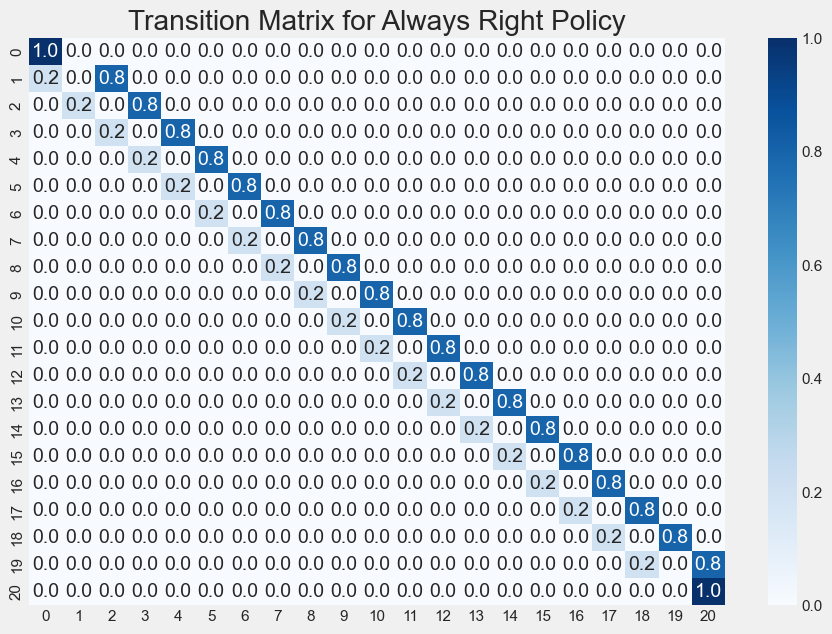

In [5]:
always_right_matrix = np.zeros((21, 21))

for i in range(1, 20):
    always_right_matrix[i, i - 1] = 0.2
    always_right_matrix[i, i + 1] = 0.8

always_right_matrix[0, 0] = 1
always_right_matrix[20, 20] = 1

sns.heatmap(always_right_matrix, cmap='Blues', annot=True, fmt='.1f')
plt.title('Transition Matrix for Always Right Policy')

## State classification

There are three classes for the states in the policy of always going right. States 0 and 20 are recurrent states because if the robot ends up in those states it will always return with a probability of 1. Since the robot cannot leave those states, they are also absorbing states.
The rest of the states are transient because the probability of returning to those states if the robot starts in them is less than 1. 


In [6]:
def classify_states(transition_matrix, state_labels):
    """
    Classify the states of a transition matrix

    Parameters;
        transition_matrix (numpy.array): a transition matrix
        state_labels (list): a list of state labels

    Returns:
        (dict): dictionary where keys are classifications and values are a list of states
    """
    classifications_dict = {}
    A, B = transition_matrix.astype(bool), transition_matrix.astype(bool)

    for i in range(transition_matrix.shape[0]):
        C = B + B.dot(A)
        if np.array_equal(B, C):
            break
        B = C

    unclassified = list(range(transition_matrix.shape[0]))
    transient_count, recurrent_count = 1, 1

    while len(unclassified):
        s = unclassified[0]
        j = np.argwhere(B[s, :] * B[:, s]).T[0]
        j = j if len(j) else [s]

        current_class = [state_labels[x] for x in j]

        # This might not always be the case but for this problem it is
        if len(current_class) > 1:
            classifications_dict["Transient Class " + str(transient_count)] = current_class
            transient_count += 1
        else:
            classifications_dict["Recurrent Class " + str(recurrent_count)] = current_class
            recurrent_count += 1

        unclassified = np.setdiff1d(unclassified, j)

    return classifications_dict


print("Classification of states for always going right")
classify_states(always_right_matrix, [i for i in range(21)])

Classification of states for always going right


{'Recurrent Class 1': [0],
 'Transient Class 1': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19],
 'Recurrent Class 2': [20]}

## Simulations

In [7]:
always_right_df = run_episodes(policy=policy_right)
always_right_df['probability'] = always_right_matrix[always_right_df['observation'], 
                                                     always_right_df['observation_next']]

always_right_df['cumulative_probability'] = always_right_df.groupby(['episode'])['probability'].cumprod()

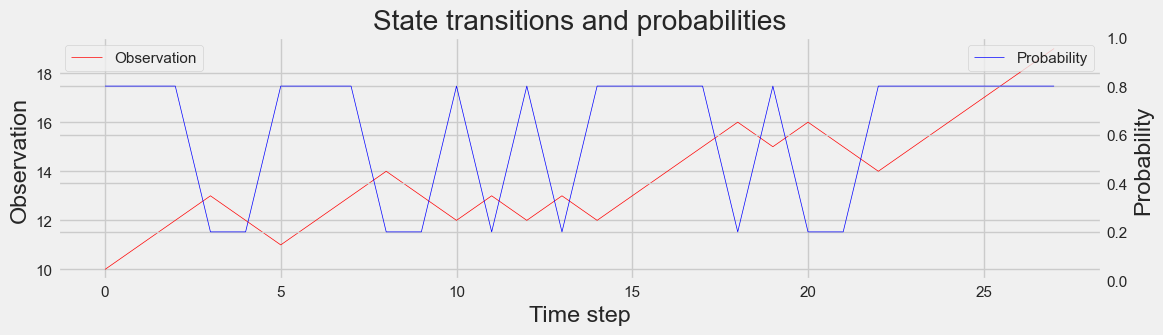

In [8]:
def plot_transitions(df):
    d = df[(df['t']>=0) & (df['t']<=100) & (df['episode']==0)]
    
    fig, ax1 = plt.subplots(figsize=(12,3))
    plt.xlabel("Time step")
    ax2 = ax1.twinx()
    ax1.set_ylabel("Observation"); ax2.set_ylabel("Probability")
    
    sns.lineplot(x='t', y='observation', data=d, ax=ax1, color='red', legend=True, 
        linewidth=0.5, label='Observation')
    
    
    sns.lineplot(x='t', y='probability', color='blue',data=d, ax=ax2, 
        legend=True, linewidth=0.5, label='Probability')
    
    ax2.set_ylim(0, 1)
    plt.title('State transitions and probabilities')

plot_transitions(always_right_df)

In [9]:
def plot_cumulative_probability(df, plot_title):
    fig = plt.figure(figsize=(12, 3))
    df_0_100 = df[(df['episode'] == 0)]
    sns.lineplot(x='t', y='cumulative_probability', color='red', data=df_0_100, 
        legend=False, linewidth=0.5)

    plt.xlabel("Time step"); plt.ylabel("Cumulative probability")
    
    plt.title(plot_title)

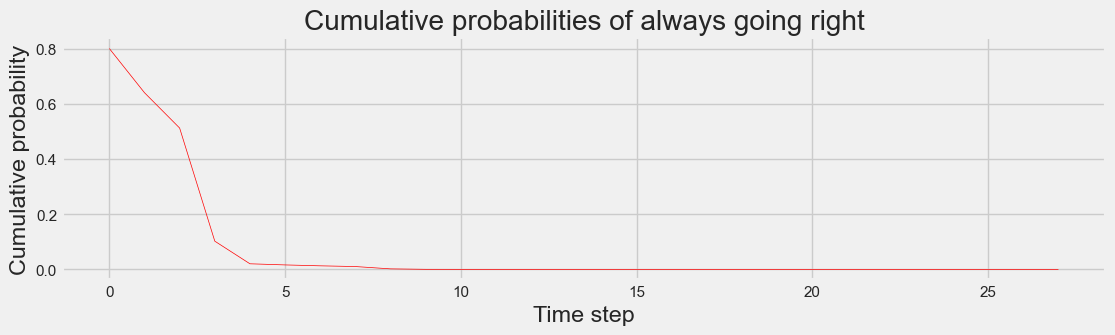

In [10]:
plot_cumulative_probability(always_right_df, 
    "Cumulative probabilities of always going right")

## Stationarity and Homogeneity

This Markov chain is nonstationary. The transition matrix is stationary because we have defined it to not depend on time but the initial state vector is nonstationarity, so the Markov chain is also nonstationary. To see this, we can see that p!=pP where p is the initial state vector and P is the transition matrix, called always_right_matrix. However, since the transition matrix is stationarity, this is a homogeneous Markov chain.

In [11]:
p = np.zeros(21)
p[10] = 1

np.array_equal(p, p.dot(always_right_matrix))

False

In [12]:
def simulate_transition_matrix(df, transition_matrix, title):
    min_obs, max_obs = 0, 20
    
    transition_df = df[['observation', 'observation_next']].dropna()
    counts = transition_df.groupby(['observation', 
        'observation_next']).size().unstack(fill_value=0)
    
    probabilities = counts.div(counts.sum(axis=1), axis=0)
    probabilities = probabilities.reindex(index=range(min_obs, max_obs + 1), 
        columns=range(min_obs, max_obs + 1), fill_value=0)
    
    probabilities.iloc[0, 0] = 1
    probabilities.iloc[20, 20] = 1
    
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(probabilities, cmap='Blues', annot=True, fmt='.1f', ax=axes[0], 
        annot_kws={"size": 6})
    axes[0].set_title('Simulated transition matrix')

    sns.heatmap(transition_matrix, cmap='Blues', annot=True, fmt='.1f', ax=axes[1], 
        annot_kws={"size": 6})
    axes[1].set_title('Actual Transition matrix')

    plt.suptitle(title)
    plt.show()

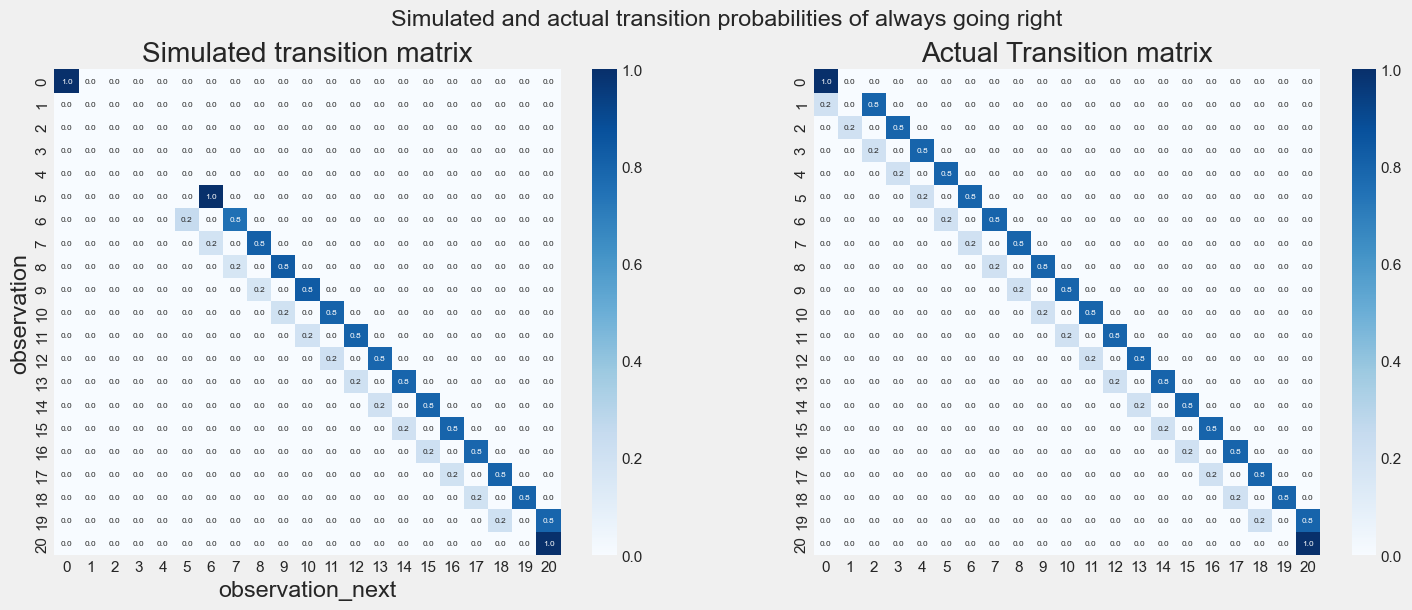

In [13]:
simulate_transition_matrix(always_right_df, always_right_matrix, 
    "Simulated and actual transition probabilities of always going right")

In these simulations the robot did not reach states 1 through 4.

#### n-step transition probability

In [14]:
def get_nstep_probability(transition_matrix):
    T = 1000
    n = 21
    P = np.zeros((T,n,n),dtype=np.float64)
    Pmat = transition_matrix
    P[0] = Pmat
    
    for t in range(1,T-1):
        P[t] = np.matmul(P[t-1],Pmat)
    
    return P

In [15]:
right_nstep_probability = get_nstep_probability(always_right_matrix)

In [16]:
def nstep_matrix(df):
    """
    Calculate state probabilities after n steps

    Parameters:
        df (pandas.DataFrame): a dataframe of transition probabilities
    """
    steps = [0, 1, 2, 3, 5, 10, 20, 50, 100]
    fig, axes = plt.subplots(3, 3, figsize=(14, 14), sharex=True, sharey=True)
    
    for i, ax in zip(steps, axes.flatten()):
        sns.heatmap(df[i, :, :], cmap='Blues', annot=True, fmt='.1f', ax=ax, 
            annot_kws={"size": 5})
        ax.set_title(f'{i}-step Transition Matrix')
    
    plt.tight_layout()
    plt.show()

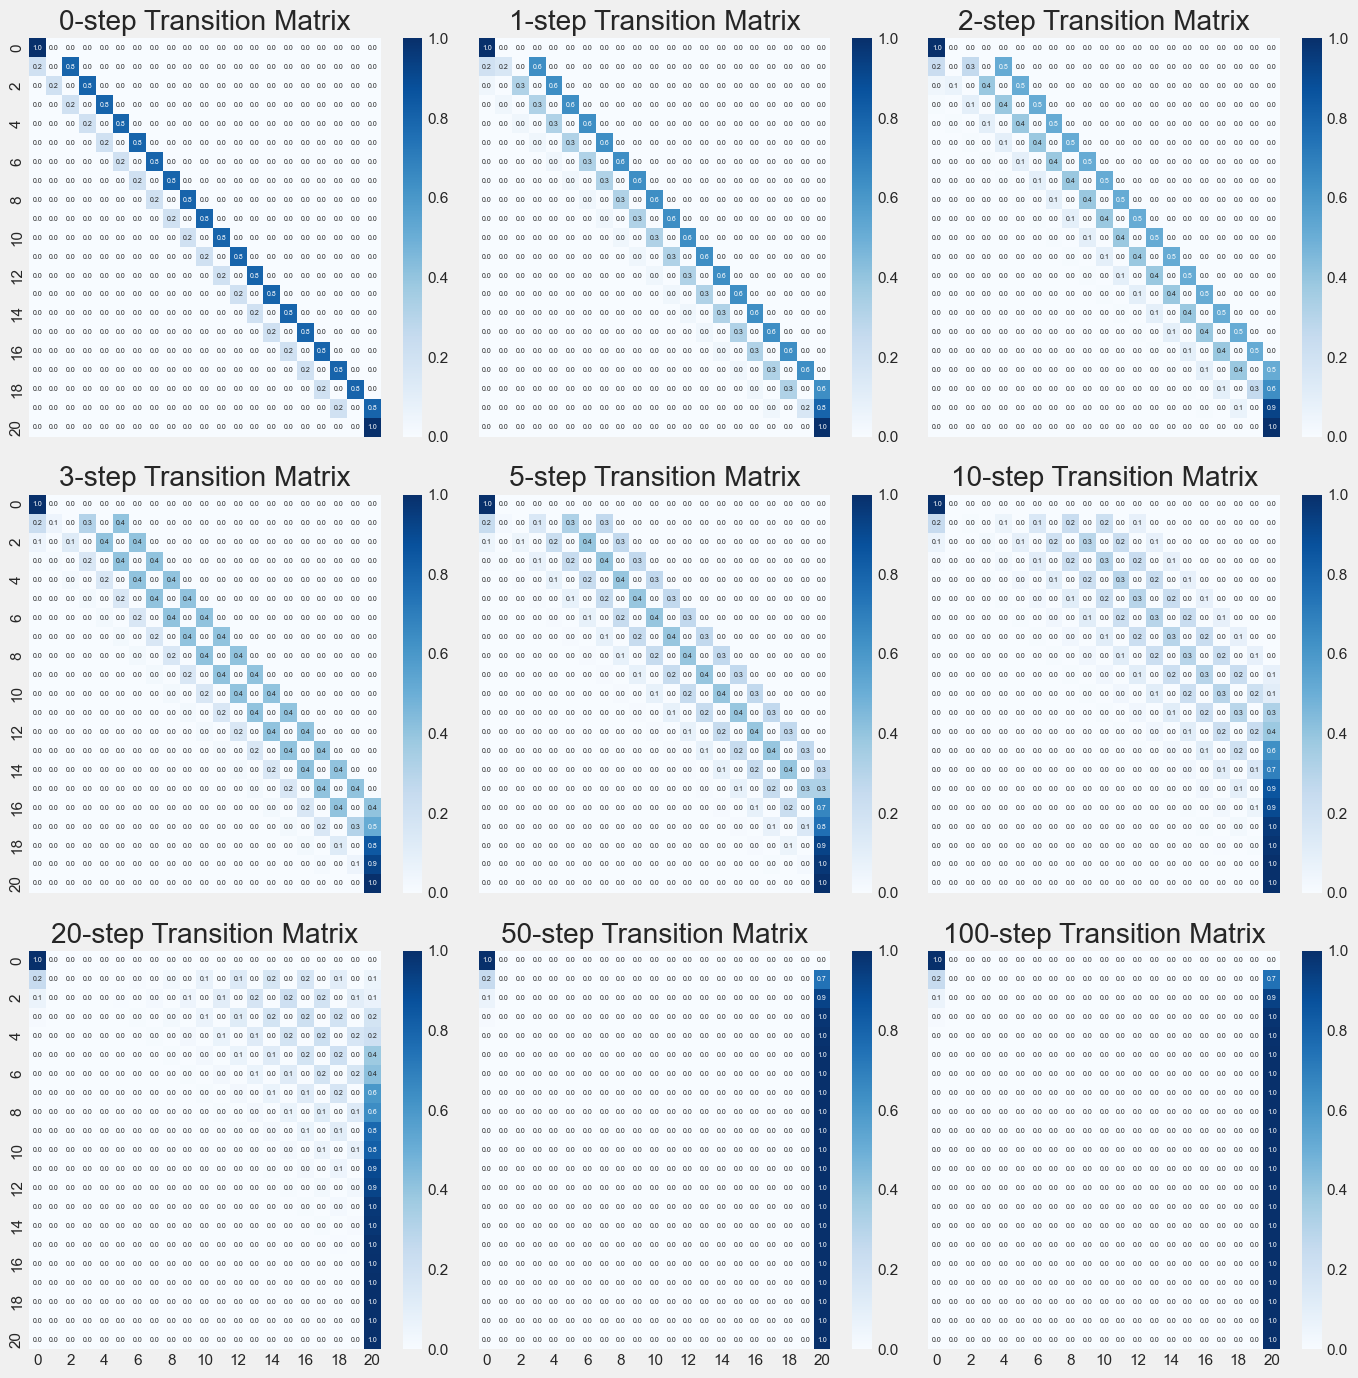

In [17]:
nstep_matrix(right_nstep_probability)

## Always going left

#### Policy

In [18]:
def policy_left(observation):
    action = 0
    return action

## Transition Matrix

Text(0.5, 1.0, 'Transition Matrix for Always left Policy')

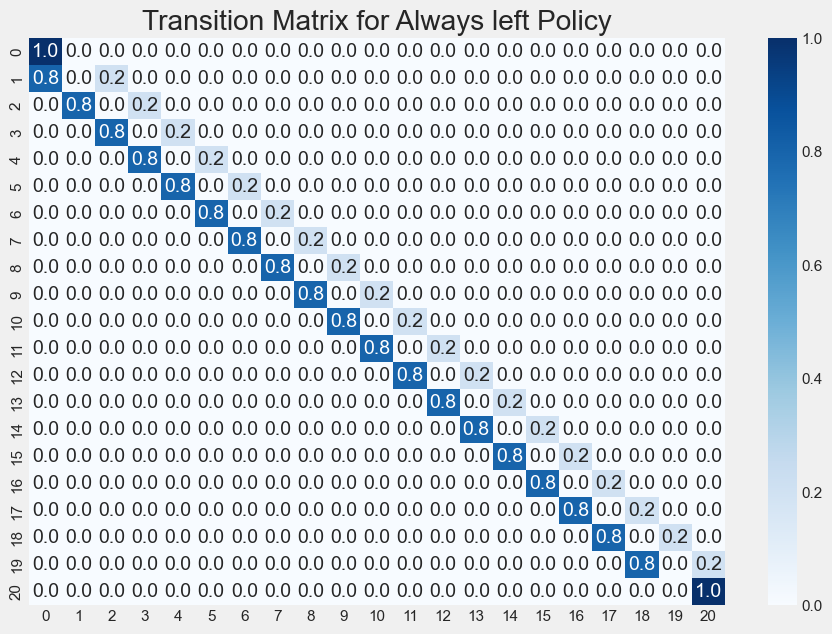

In [19]:
always_left_matrix = np.zeros((21,21))

for i in range(1,20):
    always_left_matrix[i, i - 1] = 0.8
    always_left_matrix[i, i + 1] = 0.2

always_left_matrix[0, 0] = 1
always_left_matrix[20, 20] = 1

# plot transition matrix as heatmap
sns.heatmap(always_left_matrix, cmap='Blues', annot=True, fmt='.1f')
# set title
plt.title('Transition Matrix for Always left Policy')

## State classification

There are three classes for the states in the policy of always going left. States 0 and 20 are recurrent states because if the robot ends up in those states it will always return with a probability of 1. Since the robot cannot leave those states, they are also absorbing states.
The rest of the states are transient because the probability of returning to those states if the robot starts in them is less than 1.


In [20]:
print("Classification of states for always going left")
classify_states(always_left_matrix, [i for i in range(21)])

Classification of states for always going left


{'Recurrent Class 1': [0],
 'Transient Class 1': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19],
 'Recurrent Class 2': [20]}

## Simulation

In [21]:
always_left_df = run_episodes(policy=policy_left)
always_left_df['probability'] = always_left_matrix[always_left_df['observation'], 
                                                   always_left_df['observation_next']]

always_left_df['cumulative_probability'] = always_left_df.groupby(['episode'])['probability'].cumprod()

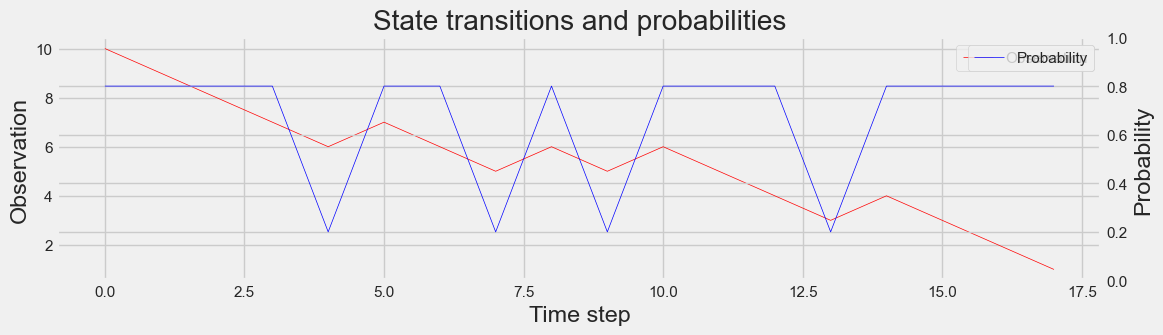

In [22]:
plot_transitions(always_left_df)

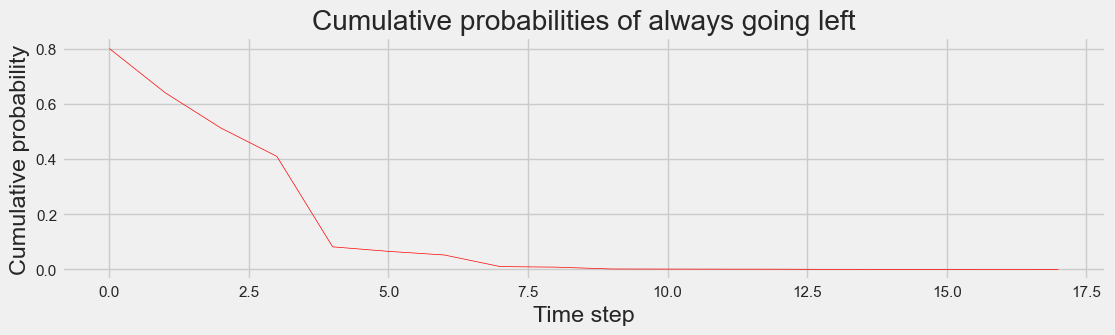

In [23]:
plot_cumulative_probability(always_left_df, 
    "Cumulative probabilities of always going left")

## Stationarity and Homogeneity

This Markov chain is nonstationary. The transition matrix is stationary because we have defined it to not depend on time but the initial state vector is nonstationarity, so the Markov chain is also nonstationary. To see this, we can see that p!=pP where p is the initial state vector and P is the transition matrix, called always_right_matrix. However, since the transition matrix is stationarity, this is a homogeneous Markov chain.
        

In [24]:
np.array_equal(p, p.dot(always_left_matrix))

False

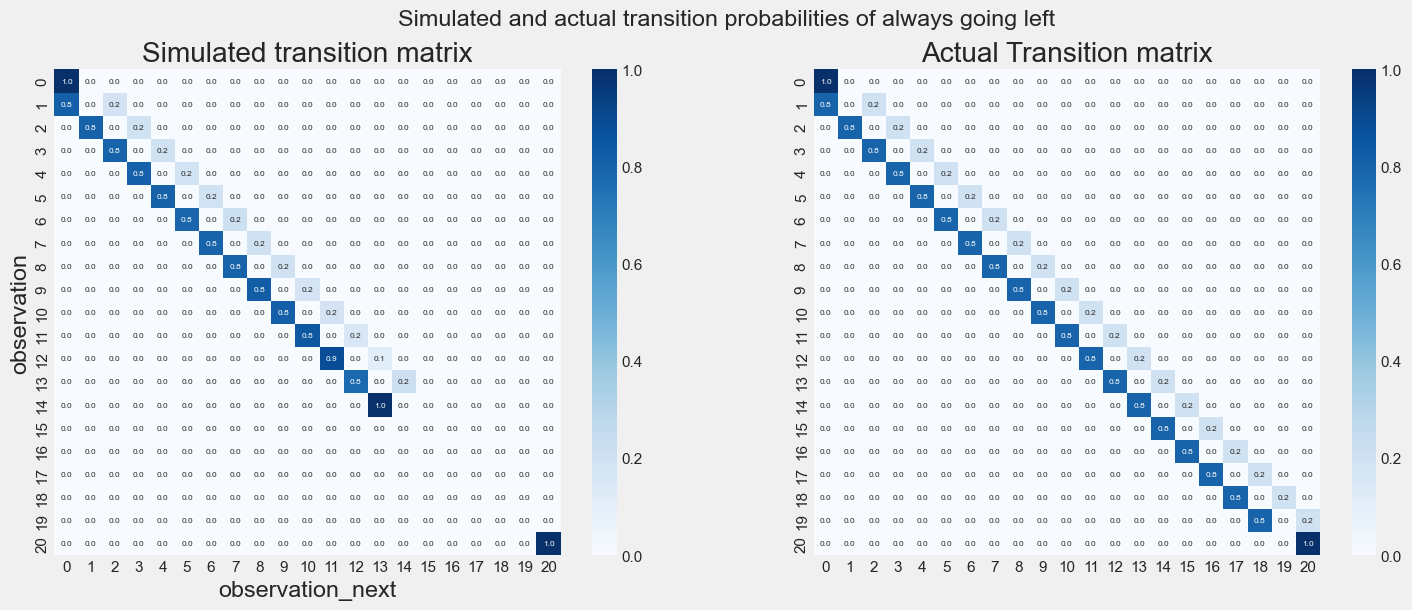

In [25]:
simulate_transition_matrix(always_left_df, always_left_matrix, 
    "Simulated and actual transition probabilities of always going left")

In the simulations the robot did not reach 15 to 19.

#### n-step transition probability

In [26]:
left_nstep_probability = get_nstep_probability(always_left_matrix)

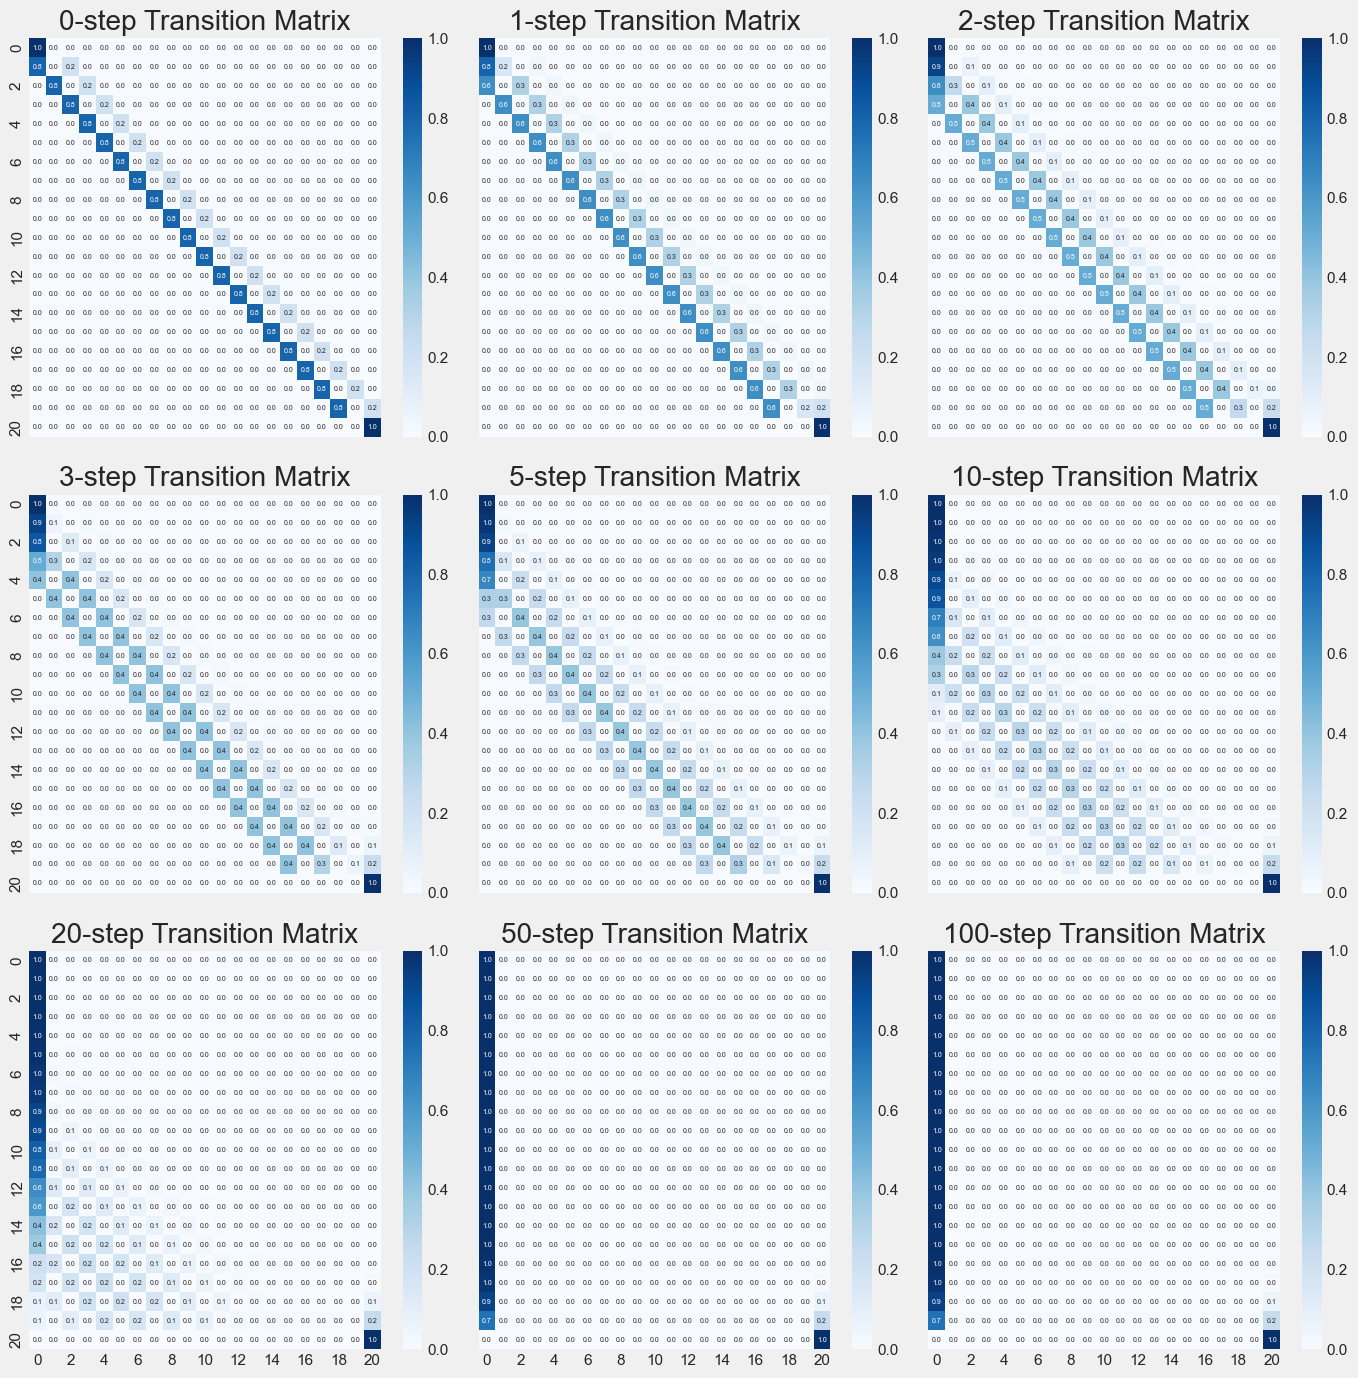

In [27]:
nstep_matrix(left_nstep_probability)

The probability of reaching state 0 increases.

## Random policy

In [28]:
def random_policy(observation):
    action = np.random.choice([0, 1], p=[0.5, 0.5])
    return action

## Transition Matrix

Text(0.5, 1.0, 'Transition matrix for a random policy')

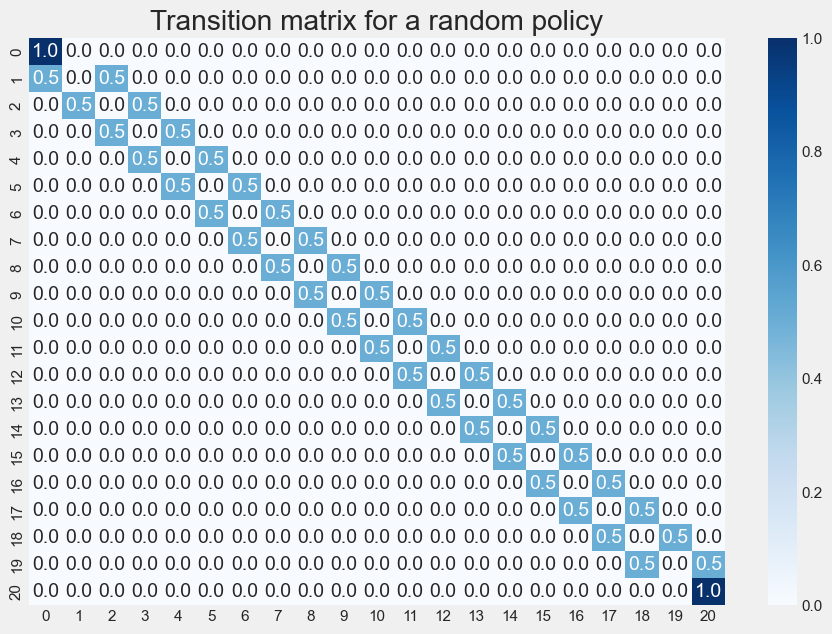

In [29]:
random_policy_matrix = np.zeros((21, 21))

for i in range(1,20):
    random_policy_matrix[i, i - 1] = 0.5
    random_policy_matrix[i, i + 1] = 0.5

random_policy_matrix[0, 0] = 1
random_policy_matrix[20, 20] = 1

sns.heatmap(random_policy_matrix, cmap='Blues', annot=True, fmt='.1f')

plt.title('Transition matrix for a random policy')

## State classification

There are three classes for the states in the random policy. States 0 and 20 are recurrent states because if the robot ends up in those states it will always return with a probability of 1. Since the robot cannot leave those states, they are also absorbing states.
The rest of the states are transient because the probability of returning to those states if the robot starts in them is less than 1. 


## Simulation

In [30]:
random_policy_df = run_episodes(policy=random_policy)
random_policy_df['probability'] = random_policy_matrix[random_policy_df['observation'], 
                                                       random_policy_df['observation_next']]

random_policy_df['cumulative_probability'] = random_policy_df.groupby(['episode'])['probability'].cumprod()

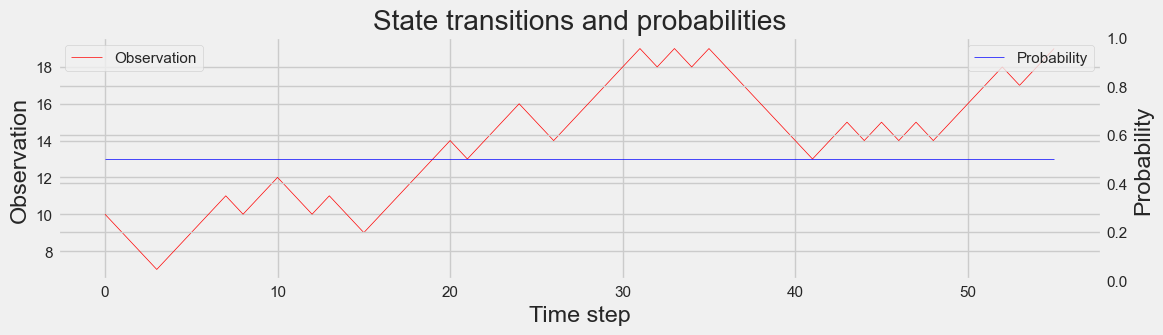

In [31]:
plot_transitions(random_policy_df)

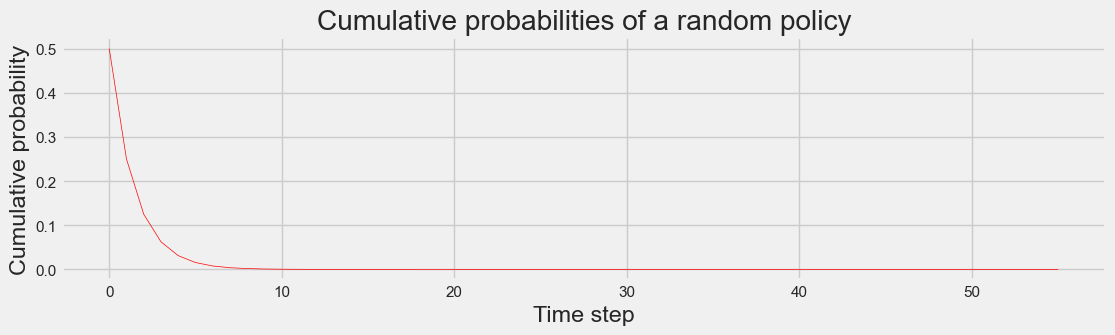

In [32]:
plot_cumulative_probability(random_policy_df, 
    "Cumulative probabilities of a random policy")

## Stationarity and Homogeneity

This Markov chain is nonstationary. The transition matrix is stationary because we have defined it to not depend on time but the initial state vector is nonstationarity, so the Markov chain is also nonstationary. To see this, we can see that p!=pP where p is the initial state vector and P is the transition matrix, called random_policy_matrix. However, since the transition matrix is stationarity, this is a homogeneous Markov chain.
        

In [33]:
np.array_equal(p, p.dot(random_policy_matrix))

False

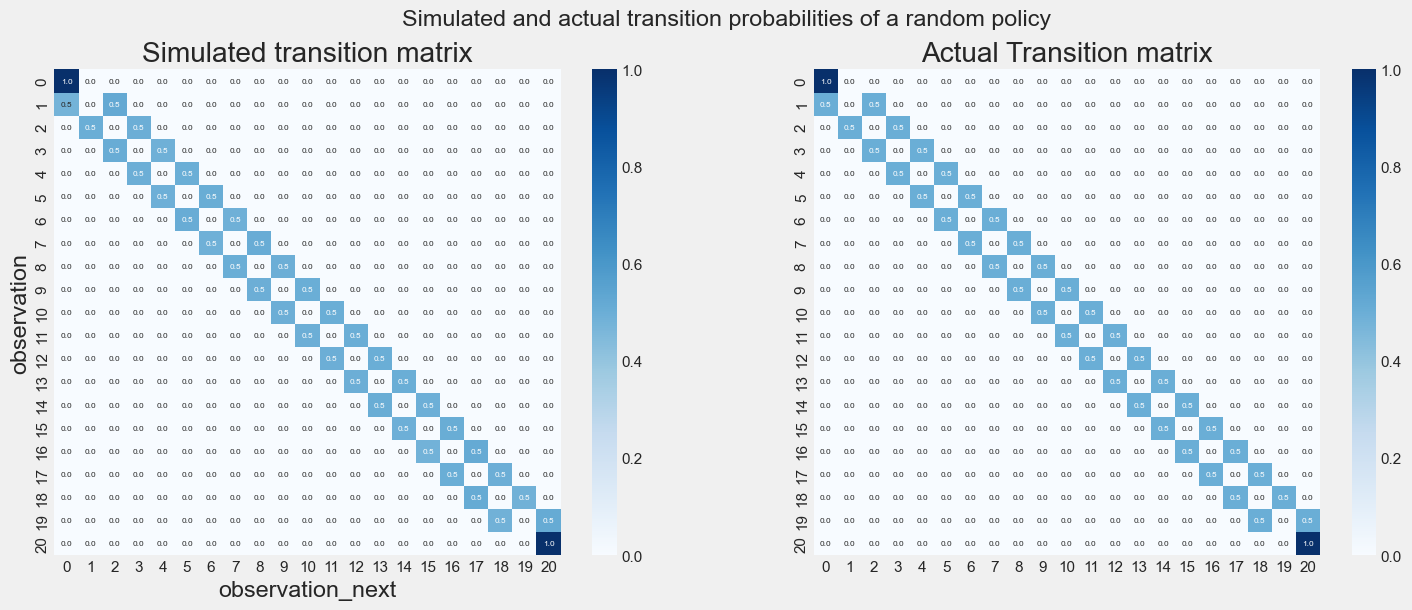

In [34]:
simulate_transition_matrix(random_policy_df, random_policy_matrix, 
    "Simulated and actual transition probabilities of a random policy")

#### n-step transition probability

In [35]:
random_nstep_probability = get_nstep_probability(random_policy_matrix)

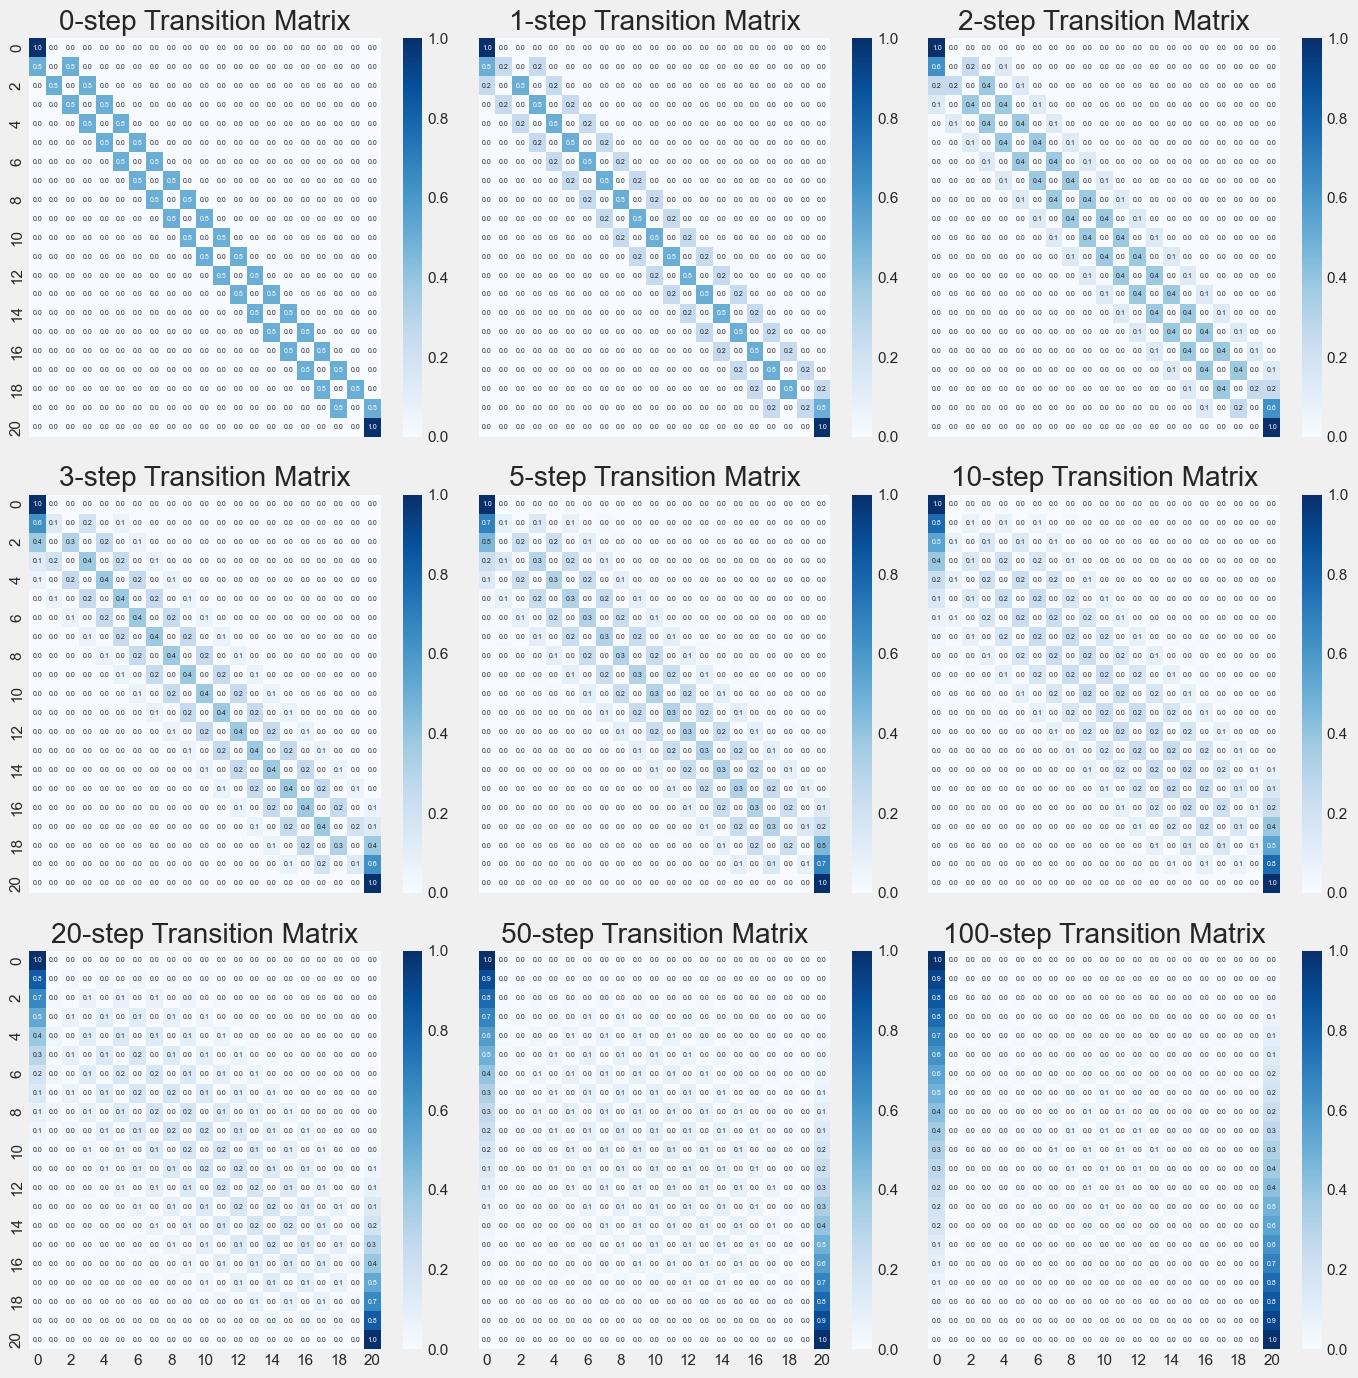

In [36]:
nstep_matrix(random_nstep_probability)

The probability of transitioning to states 0 and 20 increases.